In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary cache directory at /tmp/matplotlib-px64util because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import tensorflow as tf

2024-12-16 17:16:38.813400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 17:16:38.813481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 17:16:38.813517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 17:16:38.822386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.14.0'

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [6]:
!nvidia-smi

Mon Dec 16 17:16:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:21:00.0 Off |                  N/A |
|  0%   53C    P0             105W / 350W |      3MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Data loading

In [20]:
data = pd.read_csv('data/subreddit_body.csv')

In [21]:
df = data[['body', 'subreddit']]

In [22]:
df.head()

,body,subreddit
0,oh morality law work u think exists fed basica...,technology
1,sign contract agree really good deal compare o...,technology
2,logic equivalent people sell gun ammo responsi...,technology
3,sure could go four core like competition seem ...,technology
4,near term hydrogen simply n t compete alternat...,technology


In [23]:
df.subreddit.value_counts()

subreddit
politics       9993
science        9985
programming    9981
technology     9974
gaming         9885
Name: count, dtype: int64

In [24]:
df = pd.concat([df[df['subreddit'] == subreddit].sample(9000, random_state=42)
               for subreddit in df['subreddit'].unique()]).reset_index(drop=True)
df['subreddit'].value_counts()

subreddit
technology     9000
politics       9000
science        9000
gaming         9000
programming    9000
Name: count, dtype: int64

# Word2Vec

In [25]:
import os
os.environ['GENSIM_DATA_DIR'] = '/tf/embedding'

In [26]:
import gensim.downloader as api
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


print("Loading pre-trained Word2Vec model...")
word2vec = api.load("word2vec-google-news-300") 

text_data = df['body'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['subreddit'])
labels = y 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(text_data)
padded_sequences = pad_sequences(sequences, padding='post')

vocab_size = len(word_index) + 1
embedding_dim = word2vec.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec.key_to_index:
        embedding_matrix[i] = word2vec[word]

Loading pre-trained Word2Vec model...


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Dense Model

In [10]:
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=padded_sequences.shape[1], 
              trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 neurons for 5 classes
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=128, validation_split=0.1, verbose=1)

KeyboardInterrupt: 

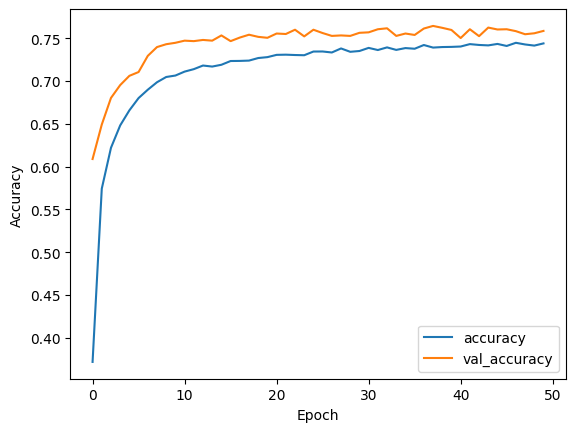

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('report/src/images/dense_accuracy.png')
plt.show()

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.7403, Accuracy: 0.7507


282/282 [==============================] - 0s 1ms/step


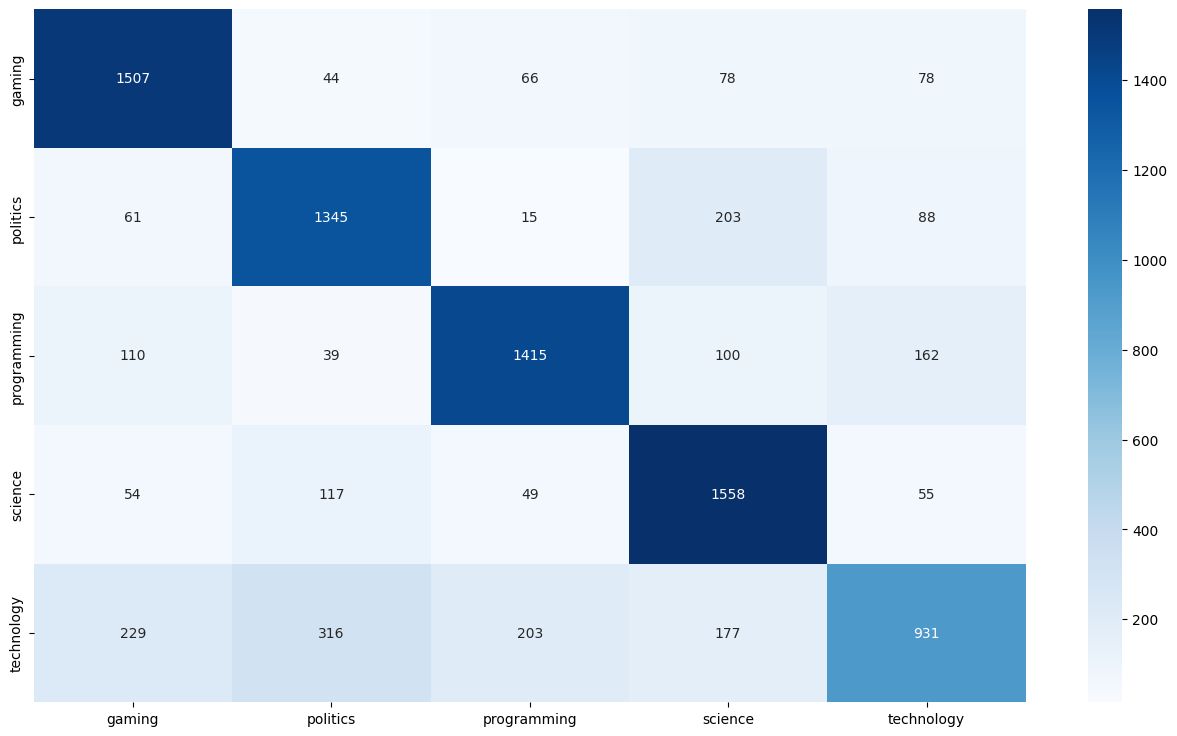

In [13]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/dense_confusion_matrix.png')
plt.show()

282/282 [==============================] - 0s 1ms/step


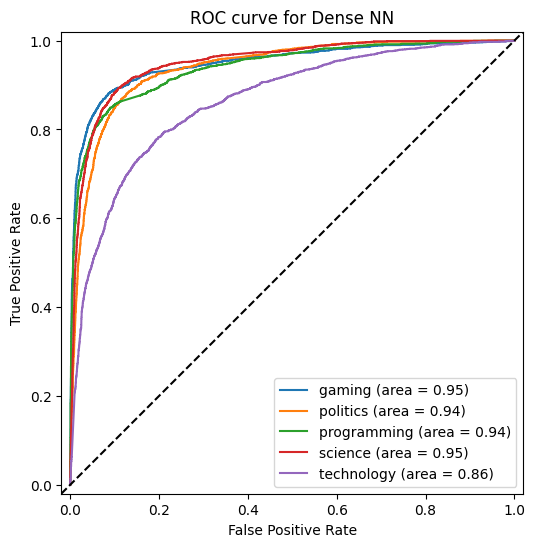

In [14]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for Dense NN')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_dense.png', bbox_inches='tight')
plt.show()

# LSTM Model

In [45]:
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=padded_sequences.shape[1], 
              trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
	Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax') 
])

model.compile(optimizer= tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=128, validation_split=0.1, verbose=1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 1072, 300)         7788900   
                                                                 
 spatial_dropout1d_14 (Spat  (None, 1072, 300)         0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_37 (Bidirect  (None, 1072, 256)         439296    
 ional)                                                          
                                                                 
 dropout_74 (Dropout)        (None, 1072, 256)         0         
                                                                 
 bidirectional_38 (Bidirect  (None, 1072, 256)         394240    
 ional)                                                          
                                                     

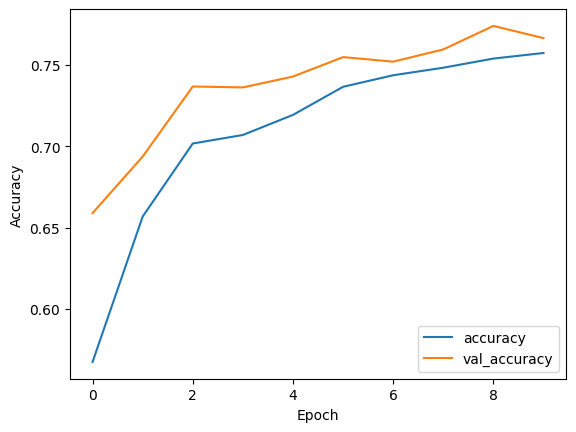

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('report/src/images/lstm_accuracy.png')
plt.show()

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 0.6985, Accuracy: 0.7629


282/282 [==============================] - 47s 160ms/step


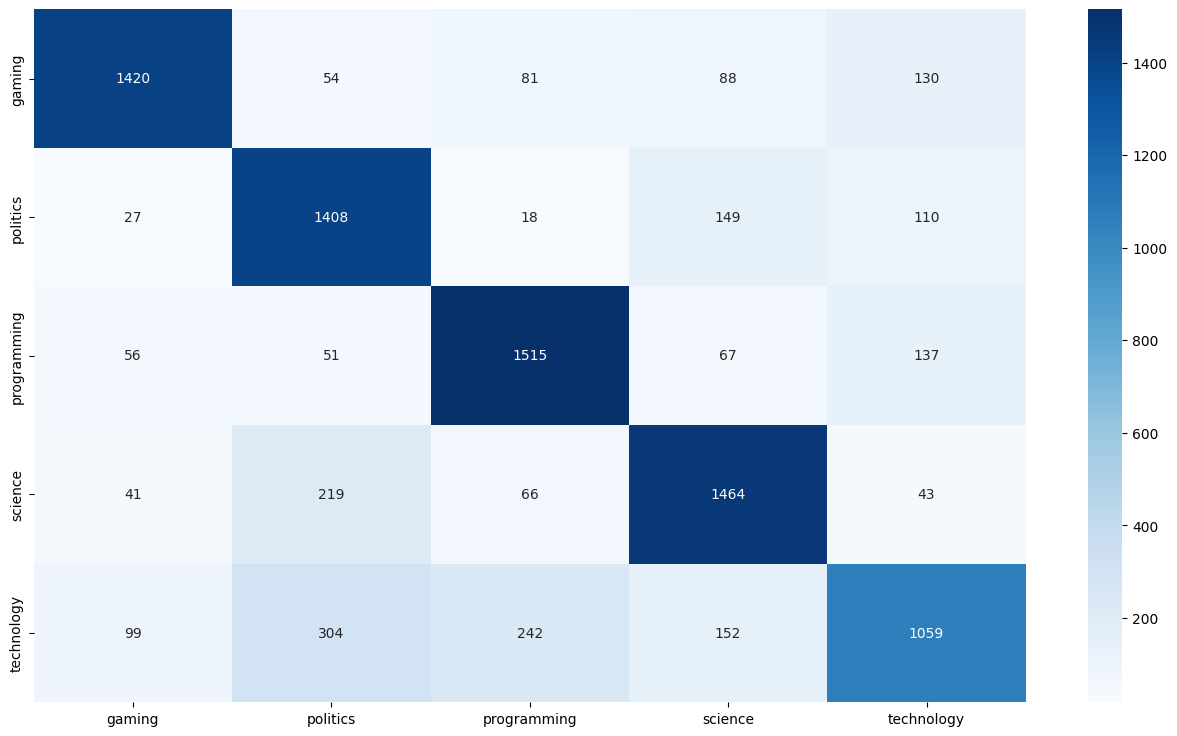

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/lstm_confusion_matrix.png')
plt.show()

282/282 [==============================] - 37s 132ms/step


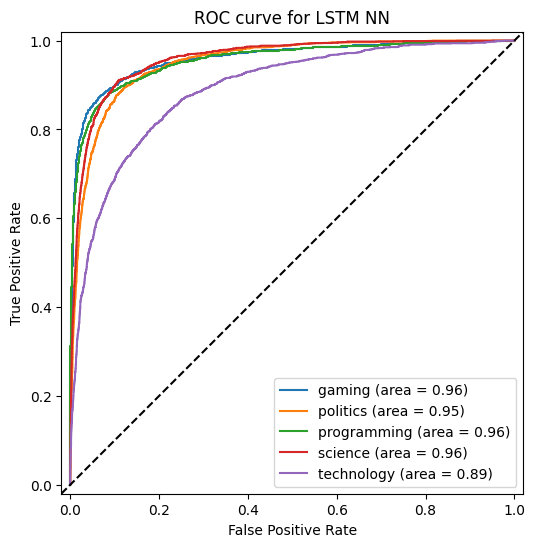

In [19]:
# plot roc curve 

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = model.predict(X_test)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for LSTM NN')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_lstm.png', bbox_inches='tight')
plt.show()

# LSTM with attention

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate attention scores
        score = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)

        # Compute context vector as the weighted sum of inputs
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=padded_sequences.shape[1], 
                               trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    AttentionLayer(),  # Add the attention layer here
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

print(model.summary())

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=30, batch_size=32, validation_split=0.1, verbose=1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1072, 300)         7788900   
                                                                 
 spatial_dropout1d_5 (Spati  (None, 1072, 300)         0         
 alDropout1D)                                                    
                                                                 
 bidirectional_11 (Bidirect  (None, 1072, 256)         439296    
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 1072, 256)         0         
                                                                 
 bidirectional_12 (Bidirect  (None, 1072, 128)         164352    
 ional)                                                          
                                                      

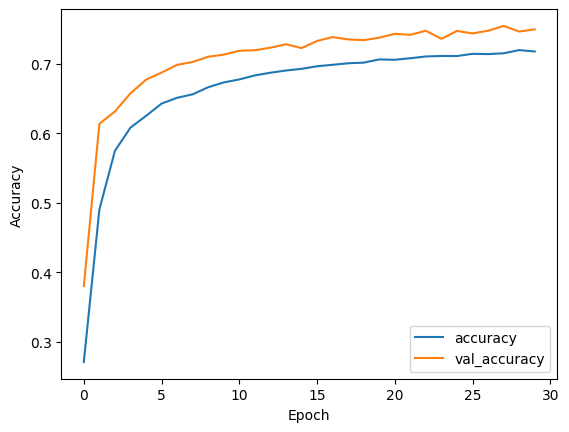

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
# plt.savefig('report/src/images/lstm_attention_accuracy.png')
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Input, Embedding, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Model

# Define the model
input_layer = Input(shape=(padded_sequences.shape[1],))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, 
                      output_dim=embedding_dim, 
                      weights=[embedding_matrix], 
                      input_length=padded_sequences.shape[1], 
                      trainable=False)(input_layer)

# Add SpatialDropout1D
spatial_dropout = tf.keras.layers.SpatialDropout1D(0.2)(embedding)

# First Bidirectional LSTM
bilstm1 = Bidirectional(LSTM(64, return_sequences=True))(spatial_dropout)
dropout1 = Dropout(0.2)(bilstm1)

# Second Bidirectional LSTM
bilstm2 = Bidirectional(LSTM(64, return_sequences=True))(dropout1)
dropout2 = Dropout(0.2)(bilstm2)

# Multi-Head Attention (No Residual Connection)
attention = MultiHeadAttention(num_heads=8, key_dim=64)(dropout2, dropout2)  # Self-attention
normalized_attention = LayerNormalization()(attention)

# Final Bidirectional LSTM
bilstm3 = Bidirectional(LSTM(32, return_sequences=False))(normalized_attention)
dropout3 = Dropout(0.2)(bilstm3)

# Dense layers with Dropout
dense1 = Dense(128, activation='relu')(dropout3)
dropout4 = Dropout(0.3)(dense1)

dense2 = Dense(64, activation='relu')(dropout4)
dropout5 = Dropout(0.3)(dense2)

dense3 = Dense(32, activation='relu')(dropout5)
dropout6 = Dropout(0.3)(dense3)

# Output layer
output_layer = Dense(5, activation='softmax')(dropout6)

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train[::16], y_train[::16], 
                    epochs=10, batch_size=4, validation_split=0.1, verbose=1)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1072)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1072, 300)    7788900     ['input_3[0][0]']                
                                                                                                  
 spatial_dropout1d_2 (SpatialDr  (None, 1072, 300)   0           ['embedding_2[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 1072, 128)   186880      ['spatial_dropout1d_2[0][0]

KeyboardInterrupt: 

# Transformer

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    attention = Dropout(dropout)(attention)
    # Residual Connection + Layer Normalization
    attention_out = LayerNormalization(epsilon=1e-6)(inputs + attention)
    
    # Feedforward Network
    ff = Dense(ff_dim, activation="relu")(attention_out)
    ff = Dropout(dropout)(ff)
    ff = Dense(inputs.shape[-1], activation=None)(ff)  # Match input shape
    # Residual Connection + Layer Normalization
    outputs = LayerNormalization(epsilon=1e-6)(attention_out + ff)
    return outputs

# Model Definition
def build_transformer_model(vocab_size, embedding_dim, max_len, num_classes, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    # Input Layer
    inputs = Input(shape=(max_len,))
    
    # Embedding Layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
    x = Dropout(dropout_rate)(embedding)
    
    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size=embedding_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout_rate)
    
    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    
    # Fully Connected Layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    
    # Output Layer
    outputs = Dense(num_classes, activation="softmax")(x)
    
    # Build Model
    model = Model(inputs, outputs)
    return model

# Hyperparameters
vocab_size = 20000
embedding_dim = 128
max_len = padded_sequences.shape[1]
num_classes = 5
num_heads = 8
ff_dim = 128
num_transformer_blocks = 2
dropout_rate = 0.1

# Build and Compile Model
model = build_transformer_model(vocab_size, embedding_dim, max_len, num_classes, num_heads, ff_dim, num_transformer_blocks, dropout_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

model.summary()

# Train the Model
history = model.fit(X_train[::8], y_train[::8], 
                    epochs=10, batch_size=4, validation_split=0.1, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1072)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1072, 128)    2560000     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1072, 128)    0           ['embedding[0][0]']              
                                                                                                  
 multi_head_attention (MultiHea  (None, 1072, 128)   527488      ['dropout[0][0]',                
 dAttention)                                                      'dropout[0][0]']            